### 1- Oriented SSD Algorithm
If you want to just see the predictions of the model just run all the cells before the training section!!!

In [1]:
%matplotlib inline
# Single Shot Multi-box Detection(SSD) #
from IPython import display
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
import time
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
from matplotlib_inline import backend_inline

In [2]:
# Utility Codes : This cell is not part of algorithm code, It is just
# for visualization purposes !!!

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_utils`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    


class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`sec_minibatch_sgd`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()
    
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)



In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
# Bounding Boxes #

def box_corner_to_center(boxes): # boxes have the shape = (n, 5) , n is the number of bounding boxes
  """Convert from (upper-left, lower-right) to (center, width, height)."""
  x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  cx = (x1 + x2) / 2
  cy = (y1 + y2) / 2
  w = x2 - x1
  h = y2 - y1
  boxes = torch.stack((cx, cy, w, h), axis=-1)
  return boxes

In [5]:

def box_center_to_corner(boxes):
  """Convert from (center, width, height) to (upper-left, lower-right)."""
  cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  x1 = cx - 0.5 * w
  y1 = cy - 0.5 * h
  x2 = cx + 0.5 * w
  y2 = cy + 0.5 * h
  boxes = torch.stack((x1, y1, x2, y2), axis=-1)
  return boxes

In [6]:
# Here `bbox` is the abbreviation for bounding box
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [7]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [8]:

def bbox_to_rect(bbox, color):
  """Convert bounding box to matplotlib format."""
  # Convert the bounding box (upper-left x, upper-left y, lower-right x,
  # lower-right y) format to the matplotlib format: ((upper-left x,
  # upper-left y), width, height)
  return plt.Rectangle(
  xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
  fill=False, edgecolor=color, linewidth=2)

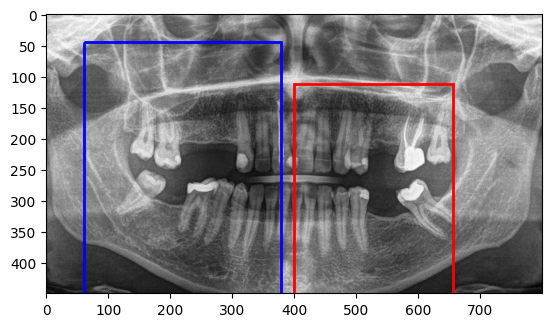

In [9]:
img = Image.open('rgb_images/0.jpg')

fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

In [10]:
# Anchor boxes #
torch.set_printoptions(2) # Simplify printing accuracy

In [11]:

def multibox_prior(data, sizes, ratios, rotations=[0.0, 45.0, 90.0, 135.0, 180]):
  """Generate anchor boxes with different shapes centered on each pixel."""
  rotations = [angle/360  for angle in rotations] 

  in_height, in_width = data.shape[-2:]
  device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
  boxes_per_pixel = (num_sizes + num_ratios - 1)
  size_tensor = torch.tensor(sizes, device=device)
  ratio_tensor = torch.tensor(ratios, device=device)
  # Offsets are required to move the anchor to the center of a pixel. Since
  # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
  offset_h, offset_w = 0.5, 0.5
  steps_h = 1.0 / in_height # Scaled steps in y axis
  steps_w = 1.0 / in_width # Scaled steps in x axis
  # Generate all center points for the anchor boxes
  center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
  center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
  shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
  shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

  # Generate `boxes_per_pixel` number of heights and widths that are later
  # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
  w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height/in_width # Handle rectangular inputs
  h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),sizes[0] / torch.sqrt(ratio_tensor[1:]))) 

  # Divide by 2 to get half height and half width
  anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
  # Each center point will have `boxes_per_pixel` number of anchor boxes, so
  # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
  out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
  output = out_grid + anchor_manipulations
  output_unsqueezed = output.unsqueeze(0)
  # Repeat anchor boxes for each rotation
  anchor_boxes_repeated = output_unsqueezed.repeat_interleave(5, dim=1)
  # Step 2: Create a tensor for rotations
  # Step 1: Repeat anchor boxes for each rotation
  num_rotations = len(rotations)
  # print(num_rotations)
  rotations_tensor = torch.tensor(rotations, dtype=torch.float32, device= device)  # Shape: (num_rotations, 1)
  # print(anchor_boxes_repeated.shape)

  rotations_tiled = rotations_tensor.repeat(anchor_boxes_repeated.shape[1] // num_rotations)
  # print(rotations_tiled.shape)
  # Step 4: Reshape rotations_tiled to add an additional dimension for concatenation
  rotations_tiled = rotations_tiled.reshape((1, rotations_tiled.shape[0], 1))  # Shape: (1, num_rotations, 1)

  # Step 5: Concatenate the repeated anchor boxes with the tiled rotations
  x_final = torch.cat([anchor_boxes_repeated, rotations_tiled], dim=2)  # Concatenate along the channel dimension
  return x_final









In [12]:
img = plt.imread('rgb_images/0.jpg')
h, w = img.shape[:2]
print(h, w)
X = torch.rand(size=(1, 3, h, w)) # Construct input data
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape
# Y

450 800


torch.Size([1, 9000000, 5])

In [13]:
from shapely.geometry import Polygon
from math import cos, sin, radians
import numpy as np
# DONE: Oriented-iou is correct

# def rotate_box(box):
#     """Calculate the four corners of a rotated box."""
#     # cx, cy, w, h, angle = box
#     x_min, y_min, x_max, y_max, angle = box
#     # angle = 0

#     cx = (x_max + x_min) / 2
#     cy = (y_min + y_max) / 2
#     w = x_max - x_min 
#     h = y_max - y_min

#     angle = radians(angle*360) # because angles are normalized between 0 and 1(devided by 360)
#     dx = w / 2
#     dy = h / 2
#     # Calculate the four corners of the rotated rectangle
#     corners = np.array([
#         [cx - dx * cos(angle) + dy * sin(angle), cy - dx * sin(angle) - dy * cos(angle)],
#         [cx + dx * cos(angle) + dy * sin(angle), cy + dx * sin(angle) - dy * cos(angle)],
#         [cx + dx * cos(angle) - dy * sin(angle), cy + dx * sin(angle) + dy * cos(angle)],
#         [cx - dx * cos(angle) - dy * sin(angle), cy - dx * sin(angle) + dy * cos(angle)]
#     ])
#     return corners

def rotate_box(box):
    """Calculate the four corners of a rotated box."""
    x_min, y_min, x_max, y_max, angle = box
    cx = (x_min + x_max) * 512  / 2
    cy = (y_min + y_max)  * 256 / 2
    w = ( x_max - x_min ) * 512  
    h = (y_max - y_min )  * 256
    angle = angle * 360
    angle = radians(angle)
    dx = w / 2
    dy = h / 2
    # Calculate the four corners of the rotated rectangle
    corners = np.array([
        [cx - dx * cos(angle) + dy * sin(angle), cy - dx * sin(angle) - dy * cos(angle)],
        [cx + dx * cos(angle) + dy * sin(angle), cy + dx * sin(angle) - dy * cos(angle)],
        [cx + dx * cos(angle) - dy * sin(angle), cy + dx * sin(angle) + dy * cos(angle)],
        [cx - dx * cos(angle) - dy * sin(angle), cy - dx * sin(angle) + dy * cos(angle)]
    ])
    return corners



def polygon_area(corners):
    """Calculate the area of a polygon given its corners."""
    poly = Polygon(corners)
    return poly.area

def polygon_intersection(corners1, corners2):
    """Calculate the intersection area between two polygons."""
    poly1 = Polygon(corners1)
    poly2 = Polygon(corners2)
    inter_area = poly1.intersection(poly2).area
    return inter_area

def box_iou_oriented(boxes1, boxes2):
    """Compute pairwise IoU for rotated bounding boxes (TensorFlow)."""
    batch_size_1 = boxes1.shape[0]
    batch_size_2 = boxes2.shape[0]
    
    iou_matrix = np.zeros((batch_size_1, batch_size_2))
    
    for i in range(batch_size_1):
        corners1 = rotate_box(boxes1[i].cpu().numpy())
        area1 = polygon_area(corners1)
        
        for j in range(batch_size_2):
            corners2 = rotate_box(boxes2[j].cpu().numpy())
            area2 = polygon_area(corners2)
            inter_area = polygon_intersection(corners1, corners2)
            union_area = area1 + area2 - inter_area
            iou_matrix[i, j] = inter_area / union_area if union_area != 0 else 0.0
    
    return torch.tensor(iou_matrix, dtype=torch.float64, device=device)


# # Example usage
boxes1 = torch.tensor([
    [20, 50, 40, 20, 15],  # x_center, y_center, width, height, angle (degrees)
    [30, 30, 20, 10, 0]
], dtype=torch.float32)

boxes2 = torch.tensor([
    [55, 55, 40, 20, 0],
    [28, 28, 20, 10, 0]
], dtype=torch.float32)

# boxes1_corner = box_center_to_corner(boxes1)
# print(boxes1_corner)
# boxes2_corner = box_center_to_corner(boxes2)
# print(boxes2_corner)
# print(boxes1[:,-1])
# boxes1_corner = torch.cat([boxes1_corner, boxes1[:,-1].unsqueeze(dim=1)], dim=1)
# print(boxes1_corner)

iou_oriented = box_iou_oriented(boxes1, boxes2)
print(iou_oriented)



# Intersection over Union (IoU) #
#@save
# def box_iou(boxes1, boxes2):
#   """Compute pairwise IoU across two lists of anchor or bounding boxes."""
#   box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]))

#   # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
#   # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)

#   areas1 = box_area(boxes1)
#   areas2 = box_area(boxes2)

#   # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
#   # boxes1, no. of boxes2, 2)
#   inter_upperlefts = torch.max(boxes1[:,None, :2], boxes2[:, :2])
#   inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
#   inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
#   # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2
#   inter_areas = inters[:, :, 0] * inters[:,:, 1]
#   union_areas = areas1[:, None] + areas2 - inter_areas
#   return inter_areas / union_areas






tensor([[1.89e-16, 9.41e-02],
        [0.00e+00, 7.20e-01]], device='cuda:0', dtype=torch.float64)


In [14]:

def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
  """Assign closest ground-truth bounding boxes to anchor boxes."""
  num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
  # Element x_ij in the i-th row and j-th column is the IoU of the anchor
  # box i and the ground-truth bounding box j
  jaccard = box_iou_oriented(anchors, ground_truth)
  # Initialize the tensor to hold the assigned ground-truth bounding box for
  # each anchor
  anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
  device=device)
  # Assign ground-truth bounding boxes according to the threshold
  max_ious, indices = torch.max(jaccard, dim=1)
  anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
  box_j = indices[max_ious >= iou_threshold]
  anchors_bbox_map[anc_i] = box_j
  col_discard = torch.full((num_anchors,), -1)
  row_discard = torch.full((num_gt_boxes,), -1)
  for _ in range(num_gt_boxes):
    max_idx = torch.argmax(jaccard) # Find the largest IoU
    box_idx = (max_idx % num_gt_boxes).long()
    anc_idx = (max_idx / num_gt_boxes).long()
    # Assign only if IoU is greater than 0
    if jaccard[anc_idx, box_idx] > 0:
            anchors_bbox_map[anc_idx] = box_idx
    # ******************************* The checking code is added ************************* #
    # anchors_bbox_map[anc_idx] = box_idx
    jaccard[:, box_idx] = col_discard
    jaccard[anc_idx, :] = row_discard
  return anchors_bbox_map



In [15]:
# Labeling Classes and Offsets
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = box_corner_to_center(anchors[:,:4]) # Feed the first 4 coordinates to the function(x_min, y_min, x_max, y_max)
    c_assigned_bb = box_corner_to_center(assigned_bb[:,:4])
    # Feed the first 4 coordinates to the function(x_min, y_min, x_max, y_max)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh =  5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])

    offset = torch.cat([offset_xy, offset_wh], dim=1)

    anchor_angles = anchors[:, -1]
    assigned_angles = assigned_bb[:, -1]
    offset_angle = assigned_angles - anchor_angles
    # print(offset_xy)
    # print(offset_wh)
    # print(offset_angle)
    offset = torch.cat([offset_xy, offset_wh, offset_angle.unsqueeze(dim=1)], axis=1)
    return offset




In [16]:

def multibox_target(anchors, labels):
  """Label anchor boxes using ground-truth bounding boxes."""
  batch_size, anchors = labels.shape[0], anchors.squeeze(0)
  batch_offset, batch_mask, batch_class_labels = [], [], []
  device, num_anchors = anchors.device, anchors.shape[0]
  for i in range(batch_size):
    label = labels[i, :, :]
    anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
    # print(anchors_bbox_map)
    # print((anchors_bbox_map >= 0).float())
    # print((anchors_bbox_map >= 0).float().unsqueeze(-1))
    bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 5)
    # print(bbox_mask)
    # Initialize class labels and assigned bounding box coordinates with
    # zeros
    class_labels = torch.zeros(num_anchors, dtype=torch.long,device=device)
    assigned_bb = torch.zeros((num_anchors, 5), dtype=torch.float32,device=device)
    # Label classes of anchor boxes using their assigned ground-truth
    # bounding boxes. If an anchor box is not assigned any, we label its
    # class as background (the value remains zero)
    indices_true = torch.nonzero(anchors_bbox_map >= 0)
    bb_idx = anchors_bbox_map[indices_true]
    class_labels[indices_true] = label[bb_idx, 0].long() + 1
    assigned_bb[indices_true] = label[bb_idx, 1:]
    # Offset transformation
    # print(offset_boxes(anchors, assigned_bb))
    offset = offset_boxes(anchors, assigned_bb) * bbox_mask
    # print(offset)
    # print(offset.shape)
    # print(offset.reshape(-1).shape)
    batch_offset.append(offset.reshape(-1))
    batch_mask.append(bbox_mask.reshape(-1))
    batch_class_labels.append(class_labels)
    print(f'Batch number: {i}\n')
    
  bbox_offset = torch.stack(batch_offset)
  bbox_mask = torch.stack(batch_mask)
  class_labels = torch.stack(batch_class_labels)
  return (bbox_offset, bbox_mask, class_labels)



In [17]:
# An Example
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92, 0],
[1, 0.55, 0.2, 0.9, 0.88, 0]], device=device)
anchors = torch.tensor([[0, 0.1, 0.2, 0.3, 0], [0.15, 0.2, 0.4, 0.4, 0],
[0.63, 0.05, 0.88, 0.98, 0], [0.66, 0.45, 0.8, 0.8, 0],
[0.57, 0.3, 0.92, 0.9, 0]], device=device)



In [18]:
labels = multibox_target(anchors.unsqueeze(dim=0),ground_truth.unsqueeze(dim=0))


Batch number: 0



In [19]:
labels[2]

tensor([[0, 1, 2, 0, 2]], device='cuda:0')

In [20]:
labels[1]

tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
         0., 0., 1., 1., 1., 1., 1.]], device='cuda:0')

In [21]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  0.00e+00,  1.40e+00,
          1.00e+01,  2.59e+00,  7.18e+00,  0.00e+00, -1.20e+00,  2.69e-01,
          1.68e+00, -1.57e+00,  0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,
         -0.00e+00,  0.00e+00, -5.71e-01, -1.00e+00,  4.17e-06,  6.26e-01,
          0.00e+00]], device='cuda:0')

In [22]:
# Predicting Bounding Boxes with Non-Maximum Suppression #

def offset_inverse(anchors, offset_preds):
  """Predict bounding boxes based on anchor boxes with predicted offsets."""
  anc = box_corner_to_center(anchors[:,:4])
  pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
  pred_bbox_wh = torch.exp(offset_preds[:, 2:4] / 5) * anc[:, 2:]
  pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
  predicted_bbox = box_center_to_corner(pred_bbox)

  pred_bbox_angle = anchors[:, -1] + offset_preds[:, -1] 
  
  # Concatenate predicted bounding box with predicted angle
  predicted_bbox_with_angle = torch.cat([predicted_bbox, pred_bbox_angle.unsqueeze(dim=1)], axis=1)
  return predicted_bbox_with_angle

In [23]:

def nms(boxes, scores, iou_threshold):
  """Sort confidence scores of predicted bounding boxes."""
  B = torch.argsort(scores, dim=-1, descending=True)
  keep = [] # Indices of predicted bounding boxes that will be kept
  # print('B:\n')
  # print(B)
  # print(f'boxes:\n{boxes}')
  # print(f'scores:\n{scores}')
  # print(f'iou_threshold:\n{iou_threshold}')
  while B.numel() > 0:
    i = B[0]
    # print(f'B[0] = i:\n{i}')
    keep.append(i)
    if B.numel() == 1: break
    # print('boxes[i, :].reshape(-1, 4):\n')
    # print(boxes[i, :].reshape(-1, 4))
    # print('boxes[B[1:], :].reshape(-1, 4):\n' )
    # print(boxes[B[1:], :].reshape(-1, 4))
    iou = box_iou_oriented(boxes[i, :].reshape(-1, 5).detach(), boxes[B[1:], :].reshape(-1, 5).detach()).reshape(-1)
    inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
    # print('iou:\n' )
    # print(iou)
    # print('inds:\n')
    # print(inds)
    
    B = B[inds + 1]
    # print('B[inds + 1]:\n')
    # print(B)
  
  # print('returned value --> keep:')
  # print(keep)
  return torch.tensor(keep, device=boxes.device)

In [24]:

def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
pos_threshold=0.009999999):
  """Predict bounding boxes using non-maximum suppression."""
  device, batch_size = cls_probs.device, cls_probs.shape[0]
  anchors = anchors.squeeze(0)
  num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
  out = []
  for i in range(batch_size):
    cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 5)
    conf, class_id = torch.max(cls_prob[1:], 0)
    predicted_bb = offset_inverse(anchors, offset_pred)
    keep = nms(predicted_bb, conf, nms_threshold)
    # Find all non-`keep` indices and set the class to background
    all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
    combined = torch.cat((keep, all_idx))
    uniques, counts = combined.unique(return_counts=True)
    non_keep = uniques[counts == 1]
    all_id_sorted = torch.cat((keep, non_keep))
    class_id[non_keep] = -1
    class_id = class_id[all_id_sorted]
    conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
    # Here `pos_threshold` is a threshold for positive (non-background)
    # predictions
    below_min_idx = (conf < pos_threshold)
    class_id[below_min_idx] = -1
    conf[below_min_idx] = 1 - conf[below_min_idx]
    pred_info = torch.cat((class_id.unsqueeze(1),conf.unsqueeze(1),predicted_bb), dim=1)
    out.append(pred_info)
  return torch.stack(out)

In [25]:
# anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
# [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
# offset_preds = torch.tensor([0] * anchors.numel())
# cls_probs = torch.tensor([[0] * 4, # Predicted background likelihood
# [0.9, 0.8, 0.7, 0.1], # Predicted dog likelihood
# [0.1, 0.2, 0.3, 0.9]]) # Predicted cat likelihood

In [26]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92, 0], [0.08, 0.2, 0.56, 0.95, 0],
[0.15, 0.3, 0.62, 0.91, 0], [0.55, 0.2, 0.9, 0.88, 0]], device=device)
offset_preds = torch.tensor([0] * anchors.numel(), device=device)
cls_probs = torch.tensor([[0] * 4, # Predicted background likelihood
[0.9, 0.8, 0.7, 0.1], # Predicted dog likelihood
[0.1, 0.2, 0.3, 0.9]], device=device) # Predicted cat likelihood

In [27]:
output = multibox_detection(cls_probs.unsqueeze(dim=0), offset_preds.unsqueeze(dim=0), anchors.unsqueeze(dim=0),nms_threshold=0.5)

In [28]:
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92,  0.00],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88,  0.00],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95,  0.00],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91,  0.00]]], device='cuda:0')

In [29]:
output.shape

torch.Size([1, 4, 7])

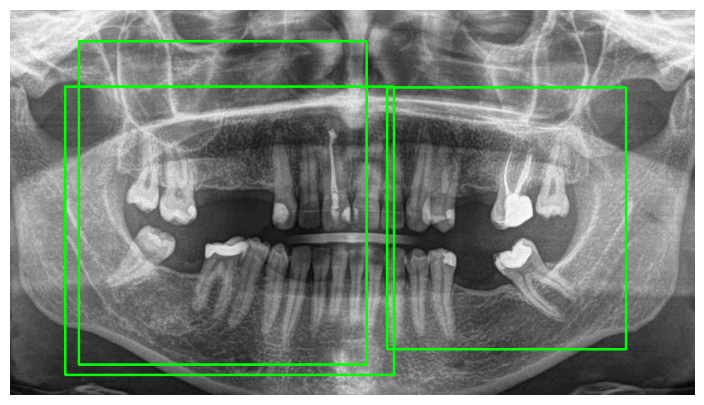

In [30]:


img_copy = np.copy(img)

def draw_rotated_box(image, box, color, thickness=2):
    # box format: (x_min, y_min, x_max, y_max, rotation_angle)
    # x_min, y_min, x_max, y_max, angle = box
    x_min, y_min, x_max, y_max, angle= box
    # angle = 0
    

    width = x_max - x_min
    height = y_max - y_min
    center = ((x_min + x_max) / 2, (y_min + y_max) / 2)
    # print(center[0], center[1] )

    # Define rectangle size and angle
    rect = ((int(center[0]) , int(center[1])), (int(width) , int(height) ), int(angle))
    # print(angle)
    # Get box points from rotated rectangle
    box_points = cv2.boxPoints(rect)
    box_points = np.int0(box_points) # Ensure integer points if len(box_points) > 0:
    # box_points = np.intp(box_points)
   

    # Draw the rotated rectangle
    return cv2.drawContours(image, [box_points], 0, color, thickness)




for row in output[0,:,:]:
    score = row[1]
    if score < 0.8:
      continue
    h, w = img_copy.shape[:2]
    bbox = row[2:7] * torch.tensor((w, h, w, h, 360), dtype=torch.float32, device=device)

    draw_rotated_box(img_copy, bbox, color=(0, 255, 0), thickness=2)


# Display the image with all bounding boxes
plt.figure(figsize=(10, 5))
plt.imshow(img_copy)
plt.axis('off')
plt.show()

In [49]:
# Multiscale Object Detection #
img = Image.open('rgb_images/23.jpg')

img = img.resize((512, 256))
image = torchvision.io.read_image('rgb_images/23.jpg').float() 

# print(self.image_files[idx], image.shape)


# # Open the image
# image = Image.open(self.image_files[idx])

# Resize image
print(image.shape)
resize_transform = torchvision.transforms.Resize((256, 512))
image = resize_transform(image)
print(image.shape)
# Normalize image
# image = image / 255.0

h, w = image.shape[1:]

print(image.shape)
print(h, w)

torch.Size([3, 452, 850])
torch.Size([3, 256, 512])
torch.Size([3, 256, 512])
256 512


In [50]:
type(image)
image.shape
print(image.permute(1,2,0).shape)

torch.Size([256, 512, 3])


In [51]:
image.permute(1,2,0)

tensor([[[208.62, 208.62, 208.62],
         [208.24, 208.24, 208.24],
         [208.39, 208.39, 208.39],
         ...,
         [209.57, 209.57, 209.57],
         [206.79, 206.79, 206.79],
         [209.62, 209.62, 209.62]],

        [[204.55, 204.55, 204.55],
         [204.55, 204.55, 204.55],
         [203.05, 203.05, 203.05],
         ...,
         [204.61, 204.61, 204.61],
         [202.94, 202.94, 202.94],
         [201.26, 201.26, 201.26]],

        [[198.34, 198.34, 198.34],
         [199.25, 199.25, 199.25],
         [199.20, 199.20, 199.20],
         ...,
         [196.82, 196.82, 196.82],
         [195.19, 195.19, 195.19],
         [197.00, 197.00, 197.00]],

        ...,

        [[ 70.47,  70.47,  70.47],
         [ 70.15,  70.15,  70.15],
         [ 73.70,  73.70,  73.70],
         ...,
         [ 78.58,  78.58,  78.58],
         [ 69.08,  69.08,  69.08],
         [ 79.20,  79.20,  79.20]],

        [[104.99, 104.99, 104.99],
         [108.31, 108.31, 108.31],
         [10

In [52]:
type(img_copy)
img_copy

array([[[205, 205, 205],
        [194, 194, 194],
        [187, 187, 187],
        ...,
        [189, 189, 189],
        [189, 189, 189],
        [176, 176, 176]],

       [[216, 216, 216],
        [211, 211, 211],
        [196, 196, 196],
        ...,
        [190, 190, 190],
        [194, 194, 194],
        [194, 194, 194]],

       [[214, 214, 214],
        [208, 208, 208],
        [201, 201, 201],
        ...,
        [181, 181, 181],
        [187, 187, 187],
        [195, 195, 195]],

       ...,

       [[ 37,  37,  37],
        [ 38,  38,  38],
        [ 35,  35,  35],
        ...,
        [ 19,  19,  19],
        [ 19,  19,  19],
        [ 18,  18,  18]],

       [[ 17,  17,  17],
        [ 25,  25,  25],
        [ 32,  32,  32],
        ...,
        [ 15,  15,  15],
        [ 15,  15,  15],
        [ 15,  15,  15]],

       [[ 22,  22,  22],
        [ 18,  18,  18],
        [ 15,  15,  15],
        ...,
        [ 10,  10,  10],
        [ 14,  14,  14],
        [ 14,  14,  14]]

In [53]:
img_copy.shape

(256, 512, 3)

In [64]:
import copy
img_copy = np.copy(img)
h, w = img_copy.shape[:2]
print(h, w)

def display_anchors(img, fmap_w, fmap_h, s):
    img_copy = copy.deepcopy(img)  # Create a fresh copy of the original image
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = multibox_prior(fmap, sizes=s, ratios=[0.5, 0.75,1])
    bbox_scale = torch.tensor((w, h, w, h, 360))
    boxes = anchors.squeeze(0)
    bbox_scale = bbox_scale.repeat((boxes.shape[0], 1))
    boxes *= bbox_scale
    boxes = boxes.tolist()
    for box in boxes[len(boxes) // 2: len(boxes)//2 + 4]:
        draw_rotated_box(img_copy, box, color=(255, 0, 0), thickness=2)
    
    # Display the image with all bounding boxes
    plt.figure(figsize=(10, 5))
    plt.imshow(img_copy)
    plt.axis('on')
    plt.show()




256 512


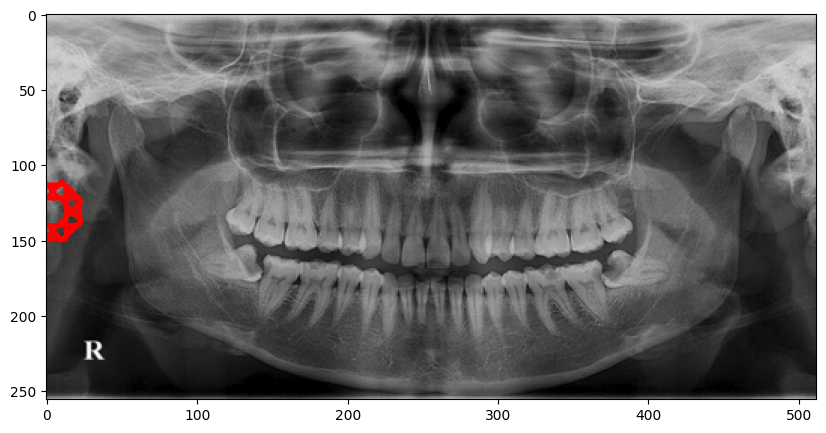

In [74]:
display_anchors(img_copy,fmap_w=64, fmap_h=32, s=[0.1, 0.15,0.2])

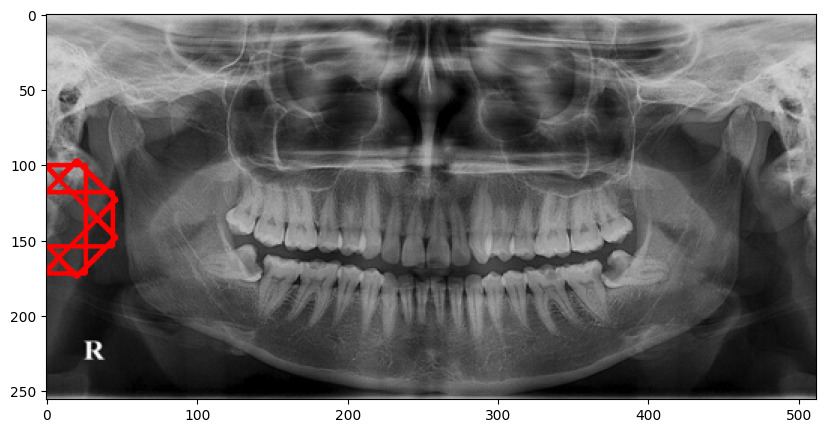

In [75]:
display_anchors(img_copy,fmap_w=32, fmap_h=16, s=[0.2, 0.3])

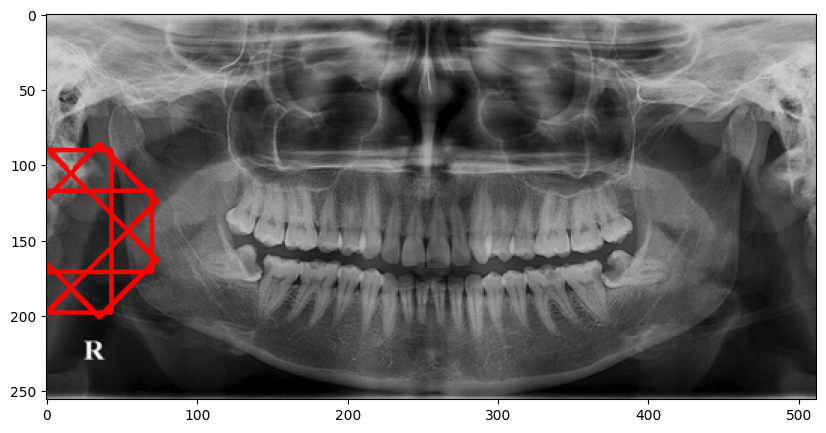

In [76]:
display_anchors(img_copy , fmap_w=16, fmap_h=8, s=[0.3, 0.4])

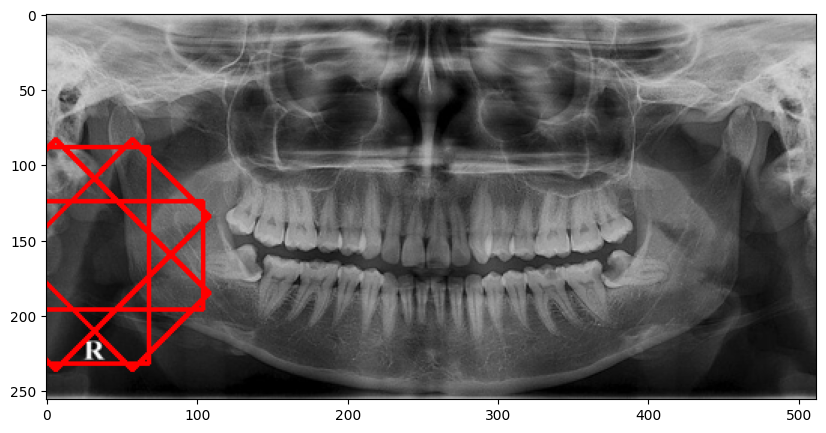

In [77]:
display_anchors(img_copy,fmap_w=8, fmap_h=4, s=[0.4, 0.5])

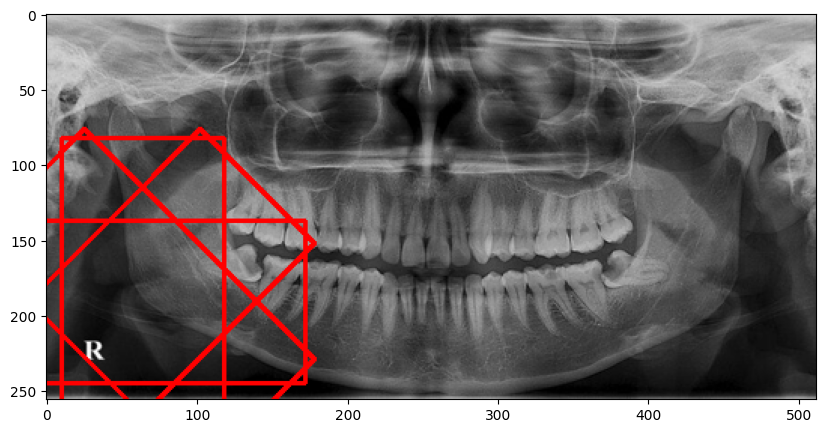

In [78]:
display_anchors(img_copy,fmap_w=4, fmap_h=2, s=[0.6])

In [79]:

# Constants
IMG_HEIGHT = 256
IMG_WIDTH = 512
MAX_BOXES = 33

# Parse labels function
def parse_label_file(label_file):
    boxes = []
    with open(label_file, 'r') as file:
        for line in file:
            if line.strip() and not line.strip().endswith(':'):
                values = list(map(float, line.strip().split(',')))
                class_id, x_min, y_min, x_max, y_max, rotation = values
                boxes.append([class_id, x_min, y_min, x_max, y_max, rotation])
    return boxes

# Padding function
def pad_labels(labels, max_boxes):
    pad_size = max_boxes - len(labels)
    if pad_size > 0:
        padding = torch.full((pad_size, len(labels[0])), -1.0)
        labels = torch.cat([torch.tensor(labels), padding], dim=0)
    else:
        labels = torch.tensor(labels[:max_boxes])
    return labels

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_files, label_files, transform=None):
        self.image_files = image_files
        self.label_files = label_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        image = torchvision.io.read_image(self.image_files[idx]).float() 

        # print(self.image_files[idx], image.shape)


        # # Open the image
        # image = Image.open(self.image_files[idx])

        # Resize image
        original_width, original_height = image.shape[2], image.shape[1]
        resize_transform = torchvision.transforms.Resize((IMG_HEIGHT, IMG_WIDTH))
        image = resize_transform(image)

        # Normalize image
        # image = image / 255.0
        

        # Load and pad label
        label = parse_label_file(self.label_files[idx])
        label = pad_labels(label, MAX_BOXES)

        # Scale bounding boxes
        scale_width = IMG_WIDTH / original_width
        scale_height = IMG_HEIGHT / original_height
        for gt_box in label:
            if gt_box[0] != -1:
                gt_box[1] = (gt_box[1] * scale_width) / IMG_WIDTH
                gt_box[2] = (gt_box[2] * scale_height) / IMG_HEIGHT
                gt_box[3] = (gt_box[3] * scale_width) / IMG_WIDTH
                gt_box[4] = (gt_box[4] * scale_height) / IMG_HEIGHT
                gt_box[5] = gt_box[5] / 360  # Normalize rotation

        return image, label

# Directories for images and labels
image_dir = './rgb_images/'
label_dir = './images/'
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if not f.endswith('.txt') and not f.endswith('.webp')]
label_files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.txt')]




# for file in image_files:
#     img = torchvision.io.read_image(file)

#     from PIL import Image
#     import torchvision.transforms as transforms

#     # Load the image and convert it to a tensor
#     image = Image.open(file)
#     image_tensor = transforms.ToTensor()(image)

#     # Check the number of channels
#     counter = 0
#     if image.mode == "L" :
#         print(f"{file} is grayscale.")
#         counter+=1
#     elif image.mode == "RGB":
#         print(f"{file} is RGB.")
#     elif image.mode == "RGBA":
#         print(f"{file} is RGBA.")
#         counter+=1
#     else:
#         counter+=1

# print(counter)

# Shuffle data and create train/val split
data = list(zip(image_files, label_files))
random.seed(10)
random.shuffle(data)
print(data.index(('./rgb_images/23.jpg', './images/23.txt')))
# split_idx = int(0.1 * len(data))
split_idx = int(1)
train_data, val_data = data[:split_idx], data[split_idx:]
train_image_files, train_label_files = zip(*train_data)
val_image_files, val_label_files = zip(*val_data)

print(train_label_files)

# Create training and validation datasets
train_dataset = ImageDataset(train_image_files, train_label_files)
val_dataset = ImageDataset(val_image_files, val_label_files)

# Create DataLoaders
train_iter = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_iter = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Example of iterating over the DataLoader
for images, labels in train_iter:
    print(images.shape)  # Should be [batch_size, 3, IMG_HEIGHT, IMG_WIDTH]
    print(labels.shape)  # Should be [batch_size, MAX_BOXES, 6]
    break


0
('./images/23.txt',)
torch.Size([1, 3, 256, 512])
torch.Size([1, 33, 6])


c:\Users\Faraz\miniconda3\envs\d2l\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [80]:
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape
batch[1][0,:,:]
# batch[0][0,:,:]

tensor([[ 0.00,  0.41,  0.42,  0.44,  0.63,  0.00],
        [ 0.00,  0.37,  0.65,  0.41,  0.82,  0.03],
        [ 0.00,  0.41,  0.67,  0.44,  0.83,  0.03],
        [ 0.00,  0.44,  0.67,  0.46,  0.84,  0.00],
        [ 0.00,  0.46,  0.67,  0.48,  0.81,  0.00],
        [ 0.00,  0.48,  0.68,  0.50,  0.80,  0.00],
        [ 0.00,  0.50,  0.68,  0.52,  0.81,  0.00],
        [ 0.00,  0.52,  0.68,  0.54,  0.83,  0.00],
        [ 0.00,  0.54,  0.68,  0.57,  0.85,  0.00],
        [ 0.00,  0.57,  0.67,  0.60,  0.85,  0.00],
        [ 0.00,  0.60,  0.66,  0.63,  0.84,  0.97],
        [ 0.00,  0.71,  0.46,  0.76,  0.59,  0.97],
        [ 0.00,  0.21,  0.57,  0.26,  0.74,  0.23],
        [ 0.00,  0.27,  0.62,  0.32,  0.81,  0.04],
        [ 0.00,  0.63,  0.64,  0.69,  0.83,  0.96],
        [ 0.00,  0.68,  0.63,  0.73,  0.82,  0.95],
        [ 0.00,  0.74,  0.60,  0.80,  0.75,  0.79],
        [ 0.00,  0.32,  0.63,  0.38,  0.81,  0.03],
        [ 0.00,  0.68,  0.46,  0.72,  0.62,  0.98],
        [ 0.

In [81]:
print(batch[0] [0, :, :].shape) # first image from the first batch
print(batch[1] [0, :, :].shape) # first label from the first batch
print(len(batch))
print(np.transpose(batch[0] [0, :, :].numpy(),(1, 2, 0)).shape)
batch[0] [0, :, :].numpy()
# batch[0] [0, :, :].numpy() * 255.0

torch.Size([3, 256, 512])
torch.Size([33, 6])
2
(256, 512, 3)


array([[[208.61719 , 208.23811 , 208.38681 , ..., 209.56845 ,
         206.79347 , 209.61719 ],
        [204.55469 , 204.55469 , 203.05273 , ..., 204.61133 ,
         202.9443  , 201.25781 ],
        [198.34375 , 199.24889 , 199.20192 , ..., 196.82227 ,
         195.18973 , 197.      ],
        ...,
        [ 70.47377 ,  70.14676 ,  73.70416 , ...,  78.57526 ,
          69.07643 ,  79.203125],
        [104.98828 , 108.30859 , 107.123886, ..., 109.38393 ,
         106.18259 , 106.47656 ],
        [149.80019 , 152.32796 , 151.07617 , ..., 156.24312 ,
         152.71306 , 151.34375 ]],

       [[208.61719 , 208.23811 , 208.38681 , ..., 209.56845 ,
         206.79347 , 209.61719 ],
        [204.55469 , 204.55469 , 203.05273 , ..., 204.61133 ,
         202.9443  , 201.25781 ],
        [198.34375 , 199.24889 , 199.20192 , ..., 196.82227 ,
         195.18973 , 197.      ],
        ...,
        [ 70.47377 ,  70.14676 ,  73.70416 , ...,  78.57526 ,
          69.07643 ,  79.203125],
        [104

[[0.0, 0.40810588002204895, 0.4158407151699066, 0.4380117356777191, 0.6338273882865906, 0.003611111082136631], [0.0, 0.37261176109313965, 0.6507079601287842, 0.40650585293769836, 0.8159734606742859, 0.02666666731238365], [0.0, 0.4052940905094147, 0.6654866933822632, 0.43521174788475037, 0.8325000405311584, 0.03055555559694767], [0.0, 0.43615293502807617, 0.6707521677017212, 0.45951762795448303, 0.8430531024932861, 0.0], [0.0, 0.45764705538749695, 0.6707521677017212, 0.4791529178619385, 0.8149114847183228, 0.0], [0.0, 0.4754117429256439, 0.676017701625824, 0.5015882253646851, 0.8043584227561951, 0.0], [0.0, 0.499717652797699, 0.6777876019477844, 0.5249646902084351, 0.8061946630477905, 0.0], [0.0, 0.5249646902084351, 0.6777876019477844, 0.5436587929725647, 0.8254645466804504, 0.0], [0.0, 0.5446000099182129, 0.676017701625824, 0.5717058777809143, 0.8483185768127441, 0.0], [0.0, 0.5679646730422974, 0.667234480381012, 0.5988234877586365, 0.8535841107368469, 0.0], [0.0, 0.5976588129997253, 0

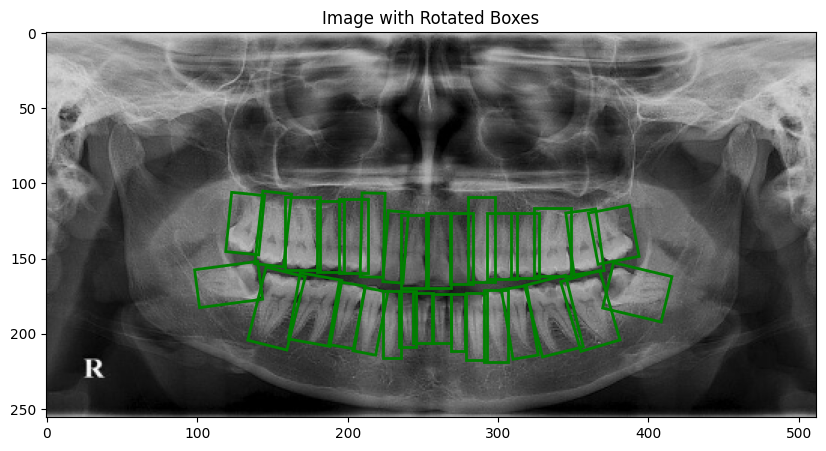

In [82]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

# def rotate_box(box):
#     """Calculate the four corners of a rotated box (TensorFlow)."""
#     x_min, y_min, x_max, y_max, angle = box
#     cx = (x_min * 512 + x_max * 512)   / 2 
#     cy = (y_min * 256 + y_max * 256)  / 2 
#     dx = (x_max * 512 - x_min * 512) / 2  
#     dy = (y_max * 256 - y_min * 256) / 2  
#     angle = radians(angle * 360)
#     # angle = 0
#     # Calculate the four corners of the rotated rectangle
#     corners = [
#         (cx - dx * cos(angle) + dy * sin(angle), cy - dx * sin(angle) - dy * cos(angle)),
#         (cx + dx * cos(angle) + dy * sin(angle), cy + dx * sin(angle) - dy * cos(angle)),
#         (cx + dx * cos(angle) - dy * sin(angle), cy + dx * sin(angle) + dy * cos(angle)),
#         (cx - dx * cos(angle) - dy * sin(angle), cy - dx * sin(angle) + dy * cos(angle))
#     ]
#     return corners

# Load the image
# image_path = 'catdog.jpg'  # Replace with your actual image path
# image = np.array(Image.open(image_path))
image = np.transpose(batch[0] [0, :, :].numpy(),(1, 2, 0))

# Example corners for rotated boxes
# Define boxes as lists of four corners (top-left, top-right, bottom-right, bottom-left)
boxes = batch[1] [0, :, :].tolist()
print(boxes)

corners_boxes = []
for box in boxes:
    if box[0] == -1:
        continue
    corners = rotate_box(box[1:])
    # print(corners)
    corners_boxes.append(corners)

boxes = corners_boxes

# boxes = [
#     [(100, 100), (200, 100), (200, 150), (100, 150)],  # First box
#     [(150, 250), (250, 230), (240, 280), (140, 300)]   # Second box
# ]
# Plotting
# fig, ax = plt.subplots()
# ax.imshow(image)
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust width and height as needed
ax.imshow(image / 255.0)
# Draw each box as a polygon
for corners in boxes:
    polygon = patches.Polygon(corners, closed=True, edgecolor='green', linewidth=2, facecolor='none')
    ax.add_patch(polygon)

plt.title("Image with Rotated Boxes")
plt.axis("on")
plt.show()

In [83]:

def cls_predictor(num_inputs, num_anchors, num_classes):
  return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
  kernel_size=3, padding=1)

In [84]:
# Bounding Box prediction layer #
def bbox_predictor(num_inputs, num_anchors):
  return nn.Conv2d(num_inputs, num_anchors * 5, kernel_size=3, padding=1)

In [85]:
def forward(x, block):
  return block(x)


Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [86]:
def flatten_pred(pred):
  return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)
def concat_preds(preds):
  return torch.cat([flatten_pred(p) for p in preds], dim=1)


In [87]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [88]:
def down_sample_blk(in_channels, out_channels):
  blk = []
  for _ in range(2):
    blk.append(nn.Conv2d(in_channels, out_channels,
    kernel_size=3, padding=1))
    blk.append(nn.BatchNorm2d(out_channels))
    blk.append(nn.ReLU())
    in_channels = out_channels
  blk.append(nn.MaxPool2d(2))
  return nn.Sequential(*blk)

In [89]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [90]:
def base_net():
  blk = []
  num_filters = [3, 16, 32, 64]
  for i in range(len(num_filters) - 1):
    blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
  return nn.Sequential(*blk)
forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [91]:
# The Complete Model #
def get_blk(i):
  if i == 0:
    blk = base_net()
  elif i == 1:
    blk = down_sample_blk(64, 128)
  elif i == 4:
    blk = nn.AdaptiveMaxPool2d((1,1))
  else:
    blk = down_sample_blk(128, 128)
  return blk

In [92]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
  Y = blk(X)
  anchors = multibox_prior(Y, sizes=size, ratios=ratio)
  # print(anchors.shape)
  cls_preds = cls_predictor(Y)
  bbox_preds = bbox_predictor(Y)
  # print('anchors shape: ----',anchors.shape)
  # print('classes shape: ----',cls_preds.shape)
  # print('bbox shape: ----' ,bbox_preds.shape)
  return (Y, anchors, cls_preds, bbox_preds)

In [93]:
# *** HERE WE HAVE DEFINED THE SIZES AND ASPECT RATIOS FOR ANCHOR BOXES *** #


# sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
# [0.88, 0.961]]
# sizes = [[0.2], [0.37], [0.54], [0.71],
# [0.88]]
# sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
# [0.88, 0.961]]
sizes = [[0.1, 0.2], [0.2 ,0.3], [0.3, 0.4], [0.4, 0.5],
[0.5, 0.6]]
# ratios = [[1, 2, 0.5]] * 5
# ratios = [[1, 2, 0.5]] * 5
# ratios = [[1, 0.5]] * 5
ratios = [[1, 0.75, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1
num_anchors = num_anchors * 5
num_classes = 1

In [94]:
class TinySSD(nn.Module):
  def __init__(self, num_classes, **kwargs):
    super(TinySSD, self).__init__(**kwargs)
    self.num_classes = num_classes
    idx_to_in_channels = [64, 128, 128, 128, 128]
    for i in range(5):
      # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
      setattr(self, f'blk_{i}', get_blk(i))
      setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
      num_anchors, num_classes))
      setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
      num_anchors))


  def forward(self, X):
    anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
    # for i in range(5):
    for i in range(2):
      # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
      X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
      # print(X.shape)
    
    # cls_preds = [cls_preds[0], cls_preds[1], cls_preds[2]]
    cls_preds = [cls_preds[0], cls_preds[1]]
    # anchors = torch.cat(anchors, dim=1)
    anchors = torch.cat([anchors[0], anchors[1]], dim=1)
    # bbox_preds = [bbox_preds[0], bbox_preds[1], bbox_preds[2]]
    bbox_preds = [bbox_preds[0], bbox_preds[1]]
    
    cls_preds = concat_preds(cls_preds)
    cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
    bbox_preds = concat_preds(bbox_preds)

    return anchors, cls_preds, bbox_preds

In [95]:
# print(device)

In [96]:
device, net = device, TinySSD(num_classes=1)
# print(net)
X = torch.zeros((1, 3, 256, 512))
anchors, cls_preds, bbox_preds = net(X)
print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)


output anchors: torch.Size([1, 51200, 5])
output class preds: torch.Size([1, 51200, 2])
output bbox preds: torch.Size([1, 256000])


In [97]:
anchors.shape

torch.Size([1, 51200, 5])

In [98]:
bbox_labels, bbox_masks, cls_labels = multibox_target(anchors.to(device='cuda'), batch[1].to(device='cuda'))

Batch number: 0



In [99]:
batch[1].shape

torch.Size([1, 33, 6])

In [100]:
bbox_labels.shape


torch.Size([1, 256000])

In [101]:
bbox_masks

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [102]:
torch.nonzero(bbox_labels)

tensor([[     0,  91250],
        [     0,  91251],
        [     0,  91252],
        ...,
        [     0, 242252],
        [     0, 242253],
        [     0, 242254]], device='cuda:0')

In [103]:
# Training #
batch_size = 32



In [104]:
print(net.parameters())

<generator object Module.parameters at 0x000001F785BE7350>


In [107]:
device, net = device, TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [108]:
# Defining Loss and Evaluation Functions #
cls_loss = nn.CrossEntropyLoss(reduction='none')
# bbox_loss = nn.L1Loss(reduction='none')
bbox_loss = nn.SmoothL1Loss(reduction='none')
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
  batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
  cls = cls_loss(cls_preds.reshape(-1, num_classes), cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
  bbox = bbox_loss(bbox_preds * bbox_masks,bbox_labels * bbox_masks).mean(dim=1)
  return cls + 3 * bbox



In [109]:
def cls_eval(cls_preds, cls_labels):
  # Because the class prediction results are on the final dimension,
  # `argmax` needs to specify this dimension
  return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())
def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
  return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

**ATTENTION PLEASE !!!!!!**

---

#### 2-Training Section

---
If you want to just see the predictions of the already trained model go to the prediction section.

"Only if you want to train the model, run the next cell and the next cell after to save the trained"





Epoch passed: 100%|██████████| 40/40 [2:18:23<00:00, 207.58s/it]

class err 7.11e-03, bbox mae 7.52e-03
0.0 examples/sec on cuda:0


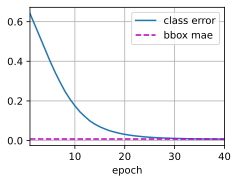

In [71]:
# Training the Model #

import time


num_epochs, timer = 40, Timer()
animator = Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['class error', 'bbox mae'])
net = net.to(device)
with tqdm(total=num_epochs, desc="Epoch passed", colour="red", position=0) as epoch_bar:
  for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    metric = Accumulator(4)
    net.train()
    with tqdm(total=len(train_iter), desc="Batch passed", colour="blue", position=1) as batch_bar:
      for features, target in train_iter:
        timer.start()
        time.sleep(0.1)  # Simulate work being done
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
        bbox_masks)
        print(l.mean())
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(), bbox_eval(bbox_preds, bbox_labels, bbox_masks),
        bbox_labels.numel())
        cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
        print(f'cls_err: {cls_err}')
        print(f'bbox_mae: {bbox_mae}')
        animator.add(epoch + 1, (cls_err, bbox_mae))

        batch_bar.update(1)  # Update inner bar for each batch
    epoch_bar.update(1)  # Update outer bar for each epoch
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on 'f'{str(device)}')

In [179]:
net.state_dict()

OrderedDict([('blk_0.0.0.weight',
              tensor([[[[ 7.18e-02, -7.35e-02,  7.53e-02],
                        [-9.36e-02,  1.46e-01,  1.33e-01],
                        [-9.99e-02, -1.03e-01,  1.75e-01]],
              
                       [[-1.89e-01,  4.80e-02,  3.25e-02],
                        [-1.82e-01, -1.43e-01,  1.23e-01],
                        [-1.11e-02, -1.10e-01,  6.38e-02]],
              
                       [[-3.51e-02, -1.99e-02,  1.64e-01],
                        [ 1.43e-01,  3.85e-02,  6.99e-02],
                        [ 1.26e-01,  1.41e-01, -1.03e-01]]],
              
              
                      [[[ 5.16e-02, -1.26e-01, -1.35e-01],
                        [ 1.82e-02,  2.55e-02, -9.62e-02],
                        [ 1.10e-01,  1.24e-01, -7.61e-03]],
              
                       [[ 1.91e-01,  4.53e-02, -1.10e-01],
                        [ 8.35e-02, -1.32e-01,  1.15e-01],
                        [-1.20e-01, -1.18e-01,  7.23e-03]],


In [ ]:
# Here The Current model is saved !!!!!

# Save weights of model
PATH_MODEL = './model'
torch.save(net.state_dict(),f'{PATH_MODEL}/model_tooth_3.pt') # Save

#### 3- Prediction section(succeeding cells ...)
This section is just for making predictions after training the model or for loading the already trained model

In [180]:
PATH_MODEL = './model'
net.load_state_dict(torch.load(f'{PATH_MODEL}/model_tooth.pt'))

# model = torch.load(f'{PATH_MODEL}/model_tooth.pt', weights_only=False)

net.eval()

TinySSD(
  (blk_0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )

In [183]:
# print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
# print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on 'f'{str(device)}')

In [184]:
net.state_dict()

OrderedDict([('blk_0.0.0.weight',
              tensor([[[[ 7.18e-02, -7.35e-02,  7.53e-02],
                        [-9.36e-02,  1.46e-01,  1.33e-01],
                        [-9.99e-02, -1.03e-01,  1.75e-01]],
              
                       [[-1.89e-01,  4.80e-02,  3.25e-02],
                        [-1.82e-01, -1.43e-01,  1.23e-01],
                        [-1.11e-02, -1.10e-01,  6.38e-02]],
              
                       [[-3.51e-02, -1.99e-02,  1.64e-01],
                        [ 1.43e-01,  3.85e-02,  6.99e-02],
                        [ 1.26e-01,  1.41e-01, -1.03e-01]]],
              
              
                      [[[ 5.16e-02, -1.26e-01, -1.35e-01],
                        [ 1.82e-02,  2.55e-02, -9.62e-02],
                        [ 1.10e-01,  1.24e-01, -7.61e-03]],
              
                       [[ 1.91e-01,  4.53e-02, -1.10e-01],
                        [ 8.35e-02, -1.32e-01,  1.15e-01],
                        [-1.20e-01, -1.18e-01,  7.23e-03]],


In [185]:
'./images/23.txt' in train_label_files

True

In [186]:
# Load and pad label
label = parse_label_file('./images/23.txt')
label = pad_labels(label, max_boxes =  33)

IMG_HEIGHT = 256
IMG_WIDTH = 512
image = torchvision.io.read_image('rgb_images/23.jpg').float() 
original_width, original_height = image.shape[2], image.shape[1]
resize_transform = torchvision.transforms.Resize((IMG_HEIGHT, IMG_WIDTH))
resized_image_X = resize_transform(image)
# print(resized_image_X.shape)
image = resized_image_X.permute(1,2,0) / 255.0
# print(image)

# Scale bounding boxes
scale_width = IMG_WIDTH / original_width
scale_height = IMG_HEIGHT / original_height
for gt_box in label:
    if gt_box[0] != -1:
      gt_box[1] = (gt_box[1] * scale_width) / IMG_WIDTH
      gt_box[2] = (gt_box[2] * scale_height) / IMG_HEIGHT
      gt_box[3] = (gt_box[3] * scale_width) / IMG_WIDTH
      gt_box[4] = (gt_box[4] * scale_height) / IMG_HEIGHT
      gt_box[5] = gt_box[5] / 360    # Normalize rotation

In [187]:
resized_image_X

tensor([[[208.62, 208.24, 208.39,  ..., 209.57, 206.79, 209.62],
         [204.55, 204.55, 203.05,  ..., 204.61, 202.94, 201.26],
         [198.34, 199.25, 199.20,  ..., 196.82, 195.19, 197.00],
         ...,
         [ 70.47,  70.15,  73.70,  ...,  78.58,  69.08,  79.20],
         [104.99, 108.31, 107.12,  ..., 109.38, 106.18, 106.48],
         [149.80, 152.33, 151.08,  ..., 156.24, 152.71, 151.34]],

        [[208.62, 208.24, 208.39,  ..., 209.57, 206.79, 209.62],
         [204.55, 204.55, 203.05,  ..., 204.61, 202.94, 201.26],
         [198.34, 199.25, 199.20,  ..., 196.82, 195.19, 197.00],
         ...,
         [ 70.47,  70.15,  73.70,  ...,  78.58,  69.08,  79.20],
         [104.99, 108.31, 107.12,  ..., 109.38, 106.18, 106.48],
         [149.80, 152.33, 151.08,  ..., 156.24, 152.71, 151.34]],

        [[208.62, 208.24, 208.39,  ..., 209.57, 206.79, 209.62],
         [204.55, 204.55, 203.05,  ..., 204.61, 202.94, 201.26],
         [198.34, 199.25, 199.20,  ..., 196.82, 195.19, 19

In [188]:
resized_image_X.shape

torch.Size([3, 256, 512])

In [189]:
resized_image_X.shape
# resized_image_X = resized_image_X / 255.0
resized_image_X.shape

torch.Size([3, 256, 512])

In [190]:
resized_image_X.shape

torch.Size([3, 256, 512])

In [191]:
# print(device)
# net
net.to(device)

TinySSD(
  (blk_0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )

In [192]:
anchors, cls_preds, bbox_preds = net(resized_image_X.unsqueeze(0).to(device))

In [193]:
print(anchors)

tensor([[[-0.02, -0.03,  0.03,  0.07,  0.00],
         [-0.02, -0.03,  0.03,  0.07,  0.12],
         [-0.02, -0.03,  0.03,  0.07,  0.25],
         ...,
         [ 0.95,  0.83,  1.02,  1.11,  0.25],
         [ 0.95,  0.83,  1.02,  1.11,  0.38],
         [ 0.95,  0.83,  1.02,  1.11,  0.50]]], device='cuda:0')


In [194]:
anchors.shape

torch.Size([1, 51200, 5])

In [195]:
# bbox_eval(bbox_preds, bbox_labels, bbox_masks),bbox_labels.numel())

In [196]:
bbox_masks.reshape(1,-1,5).shape
# anchors.shape

torch.Size([1, 51200, 5])

In [197]:
assigned_anchors = anchors * bbox_masks.reshape(1,-1,5)

In [198]:
bbox_preds.reshape(1,-1,5)

tensor([[[ 0.23,  0.38, -0.29,  0.19, -0.43],
         [ 0.73, -0.17,  0.63, -0.80,  0.75],
         [ 0.53, -0.05, -0.35,  0.14, -0.03],
         ...,
         [ 0.05,  0.41, -0.19,  0.03, -0.42],
         [-0.64, -0.05,  0.44, -0.71, -0.21],
         [ 0.54,  0.04,  0.58, -0.10, -0.01]]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

In [199]:
bbox_offset, bbox_mask, class_labels = multibox_target(anchors, label.unsqueeze(0).to(device=device))

Batch number: 0



In [201]:
bbox_preds.shape

torch.Size([1, 256000])

In [202]:
print(bbox_preds)

tensor([[ 0.23,  0.38, -0.29,  ...,  0.58, -0.10, -0.01]], device='cuda:0',
       grad_fn=<CatBackward0>)


In [203]:

anchors_assigned = anchors * bbox_mask.reshape(1,-1,5)
print('Anchors: ', anchors)
# print(bbox_masks)
print('Assigned anchors: ', anchors_assigned)
# print(anchors_assigned[anchors_assigned > 1])

Anchors:  tensor([[[-0.02, -0.03,  0.03,  0.07,  0.00],
         [-0.02, -0.03,  0.03,  0.07,  0.12],
         [-0.02, -0.03,  0.03,  0.07,  0.25],
         ...,
         [ 0.95,  0.83,  1.02,  1.11,  0.25],
         [ 0.95,  0.83,  1.02,  1.11,  0.38],
         [ 0.95,  0.83,  1.02,  1.11,  0.50]]], device='cuda:0')
Assigned anchors:  tensor([[[-0., -0., 0., 0., 0.],
         [-0., -0., 0., 0., 0.],
         [-0., -0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]], device='cuda:0')


In [204]:
assigned_anchors.shape

torch.Size([1, 51200, 5])

In [205]:
bbox_preds.reshape(1, -1, 5)

tensor([[[ 0.23,  0.38, -0.29,  0.19, -0.43],
         [ 0.73, -0.17,  0.63, -0.80,  0.75],
         [ 0.53, -0.05, -0.35,  0.14, -0.03],
         ...,
         [ 0.05,  0.41, -0.19,  0.03, -0.42],
         [-0.64, -0.05,  0.44, -0.71, -0.21],
         [ 0.54,  0.04,  0.58, -0.10, -0.01]]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

In [206]:
bbox_mask.shape

torch.Size([1, 256000])

In [207]:
bbox_preds = (bbox_preds * bbox_mask).reshape(-1,5)
bbox_preds.shape

torch.Size([51200, 5])

In [208]:
# predicted_bbox_with_angle = offset_inverse(anchors=anchors_assigned.squeeze(0), offset_preds=bbox_offset)
predicted_bbox_with_angle = offset_inverse(anchors=anchors_assigned.squeeze(0), offset_preds=bbox_preds)
print(predicted_bbox_with_angle)
print(predicted_bbox_with_angle.shape)
predicted_bbox_with_angle.cpu().device

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0', grad_fn=<CatBackward0>)
torch.Size([51200, 5])


device(type='cpu')

In [209]:
predicted_bbox_with_angle=predicted_bbox_with_angle * bbox_masks.reshape(-1,5)

In [210]:
bbox_masks.reshape(-1,5).shape

torch.Size([51200, 5])

In [211]:
predicted_bbox_with_angle

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0', grad_fn=<MulBackward0>)

In [212]:
predicted_bbox_with_angle

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0', grad_fn=<MulBackward0>)

In [213]:
predicted_bbox_with_angle.shape
torch.nonzero(predicted_bbox_with_angle).shape

torch.Size([1605, 2])

[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], 

  0%|          | 0/33 [00:00<?, ?it/s]

0.006435633772422371
[0.3500889539718628, 0.3981221914291382, 0.3861547112464905, 0.572231650352478, 0.16494546830654144]
0.118966390178935
[0.3762253224849701, 0.4423556327819824, 0.4192008078098297, 0.5392159223556519, 0.28618940711021423]
0.14134441174887608
[0.3761692941188812, 0.42794573307037354, 0.4217410385608673, 0.5414938926696777, 0.3673756718635559]
0.19235245170282905
[0.3816113770008087, 0.39946115016937256, 0.4168231785297394, 0.5694102048873901, 0.383573442697525]
0.21023130905508366
[0.38056549429893494, 0.4227970838546753, 0.416944295167923, 0.5974161624908447, 0.34919455647468567]
0.4729255443301857
[0.4133010506629944, 0.4342007040977478, 0.4502943158149719, 0.5952737927436829, 0.027996597811579704]


  3%|▎         | 1/33 [00:07<03:47,  7.11s/it]

0.026530580779838876
[0.3806328773498535, 0.488092839717865, 0.4134659767150879, 0.6609625220298767, 0.0002816319465637207]
0.04929321940497598
[0.3253173828125, 0.6338198781013489, 0.37961632013320923, 0.767103374004364, 0.49965041875839233]
0.10848763242775353
[0.33728280663490295, 0.6318719387054443, 0.36924371123313904, 0.7823987007141113, 0.23718665540218353]
0.12696350252027228
[0.33374831080436707, 0.6478904485702515, 0.37013086676597595, 0.8184481859207153, 0.18181276321411133]
0.14240855574453604
[0.3352515995502472, 0.6477211713790894, 0.3684018552303314, 0.8131730556488037, -0.21614879369735718]
0.4748459331583119
[0.35878148674964905, 0.6873098611831665, 0.4044993221759796, 0.7921286821365356, -0.0843656063079834]
0.4940066550208654
[0.3558633625507355, 0.6702585816383362, 0.408762127161026, 0.7842889428138733, 0.5585861802101135]
0.5898579951684628
[0.38064149022102356, 0.6488160490989685, 0.41448280215263367, 0.8247705101966858, 0.00010225176811218262]


  6%|▌         | 2/33 [00:14<03:40,  7.12s/it]

0.023896556617517772
[0.35878148674964905, 0.6873098611831665, 0.4044993221759796, 0.7921286821365356, -0.0843656063079834]
0.02400859256380579
[0.3558633625507355, 0.6702585816383362, 0.408762127161026, 0.7842889428138733, 0.5585861802101135]
0.15040812413760452
[0.36542612314224243, 0.6492620706558228, 0.40230268239974976, 0.8228572607040405, 0.2291802316904068]
0.2372326085517578
[0.38216710090637207, 0.6516155004501343, 0.4162914752960205, 0.8116689920425415, 0.16065238416194916]
0.328552837550101
[0.39844515919685364, 0.6509895324707031, 0.43387076258659363, 0.8203847408294678, -0.1116783618927002]
0.33183528551329255
[0.39667055010795593, 0.6442180275917053, 0.4322876036167145, 0.8243268132209778, 0.1590411365032196]
0.5383001170537239
[0.4109781086444855, 0.6485533714294434, 0.44613638520240784, 0.8207646608352661, 0.008332699537277222]
0.6366520560010253
[0.3976200520992279, 0.6727805733680725, 0.43359383940696716, 0.8524561524391174, 0.06374529004096985]


  9%|▉         | 3/33 [00:21<03:36,  7.21s/it]

0.022825267649511073
[0.4611493945121765, 0.5137447118759155, 0.49173611402511597, 0.6986963748931885, 0.059571415185928345]
0.09662392150893645
[0.39844515919685364, 0.6509895324707031, 0.43387076258659363, 0.8203847408294678, -0.1116783618927002]
0.13599014327627257
[0.39667055010795593, 0.6442180275917053, 0.4322876036167145, 0.8243268132209778, 0.1590411365032196]
0.28572487153155596
[0.4146890640258789, 0.6465539336204529, 0.44955819845199585, 0.8166170716285706, -0.0769464299082756]
0.4749874980888729
[0.42755091190338135, 0.6617065668106079, 0.46223562955856323, 0.8217252492904663, 0.5668825507164001]


 12%|█▏        | 4/33 [00:29<03:34,  7.40s/it]

0.003837976594261153
[0.4601150155067444, 0.5089572072029114, 0.4955843687057495, 0.6873728632926941, -0.5688430070877075]
0.06415068040822845
[0.4611493945121765, 0.5137447118759155, 0.49173611402511597, 0.6986963748931885, 0.059571415185928345]
0.2319442587889867
[0.4315362870693207, 0.6555870771408081, 0.46446743607521057, 0.8196777105331421, 0.15748783946037292]
0.39249159895019997
[0.44595807790756226, 0.6529839038848877, 0.4801046848297119, 0.8160198926925659, -0.09549665451049805]


 15%|█▌        | 5/33 [00:36<03:20,  7.17s/it]

0.02248139328602355
[0.4601150155067444, 0.5089572072029114, 0.4955843687057495, 0.6873728632926941, -0.5688430070877075]
0.06682332483278136
[0.4315362870693207, 0.6555870771408081, 0.46446743607521057, 0.8196777105331421, 0.15748783946037292]
0.1642662833454927
[0.44595807790756226, 0.6529839038848877, 0.4801046848297119, 0.8160198926925659, -0.09549665451049805]
0.21566660311294217
[0.44439002871513367, 0.6590473055839539, 0.4770526587963104, 0.8139476180076599, -0.18994200229644775]
0.283288764445481
[0.4568537175655365, 0.6476699709892273, 0.49337664246559143, 0.8151680827140808, -0.35492703318595886]
0.3299507088502199
[0.4594040513038635, 0.6623116731643677, 0.49179571866989136, 0.8150211572647095, 0.3566705882549286]
0.4644443566398463
[0.46919435262680054, 0.6778993606567383, 0.5226150155067444, 0.7922592163085938, -0.012615323066711426]
0.5407520738909657
[0.4699079394340515, 0.6904150247573853, 0.5137313008308411, 0.7865704298019409, -0.5687620043754578]
0.5559339658853338
[

 18%|█▊        | 6/33 [00:43<03:12,  7.12s/it]

4.2920302897333716e-05
[0.44595807790756226, 0.6529839038848877, 0.4801046848297119, 0.8160198926925659, -0.09549665451049805]
0.0032212667066468087
[0.44439002871513367, 0.6590473055839539, 0.4770526587963104, 0.8139476180076599, -0.18994200229644775]
0.08405772548863445
[0.4568537175655365, 0.6476699709892273, 0.49337664246559143, 0.8151680827140808, -0.35492703318595886]
0.37888658689749827
[0.46919435262680054, 0.6778993606567383, 0.5226150155067444, 0.7922592163085938, -0.012615323066711426]
0.47915278432387814
[0.4813153147697449, 0.6846204996109009, 0.5320584177970886, 0.7865884304046631, -0.17946571111679077]
0.4985108502764457
[0.48632708191871643, 0.6831962466239929, 0.5312132835388184, 0.792786180973053, 0.13817526400089264]
0.5810449698915571
[0.49386852979660034, 0.6844261288642883, 0.5257653594017029, 0.8447746634483337, 0.4947494864463806]


 21%|██        | 7/33 [00:49<03:02,  7.02s/it]

0.0008729482826941767
[0.47169920802116394, 0.6710891723632812, 0.5128240585327148, 0.7960947751998901, 0.2705778181552887]
0.0011660537041199032
[0.4714319705963135, 0.662813663482666, 0.5090817213058472, 0.7902348041534424, 0.14705142378807068]
0.0064952899222093475
[0.47584715485572815, 0.650039553642273, 0.507990300655365, 0.8130398988723755, -0.392162561416626]
0.08635070209306973
[0.4813153147697449, 0.6846204996109009, 0.5320584177970886, 0.7865884304046631, -0.17946571111679077]
0.17460678048816805
[0.4883561432361603, 0.6821147203445435, 0.5324949622154236, 0.7931922674179077, 0.7166270017623901]
0.19760070410667055
[0.5370765328407288, 0.6530994176864624, 0.5737355351448059, 0.8147724866867065, -0.2972825765609741]
0.36390976824646315
[0.5221328735351562, 0.6782482862472534, 0.5551354885101318, 0.8522453308105469, -0.08509151637554169]


 24%|██▍       | 8/33 [00:56<02:52,  6.91s/it]

0.0006875611900024257
[0.4915449321269989, 0.6552813053131104, 0.5245867967605591, 0.8010820150375366, -0.36412313580513]
0.0009684608705773988
[0.4904162287712097, 0.6537255048751831, 0.5233458876609802, 0.8124117851257324, 0.12709060311317444]
0.5472357762281628
[0.5385807156562805, 0.6439082622528076, 0.5738598704338074, 0.8227804899215698, 0.5224736332893372]
0.728629520434456
[0.5392026901245117, 0.6861351728439331, 0.5732133388519287, 0.8422143459320068, 0.013306943699717522]
0.7332120316839036
[0.5377610921859741, 0.6803696155548096, 0.5707920789718628, 0.8492223024368286, -0.48867231607437134]


 27%|██▋       | 9/33 [01:03<02:45,  6.89s/it]

0.07258314922915027
[0.5385807156562805, 0.6439082622528076, 0.5738598704338074, 0.8227804899215698, 0.5224736332893372]
0.2065644585688429
[0.5370765328407288, 0.6530994176864624, 0.5737355351448059, 0.8147724866867065, -0.2972825765609741]
0.23989509279633017
[0.568386435508728, 0.6510894894599915, 0.6026812791824341, 0.8116868138313293, 0.2879526615142822]
0.2399403327827241
[0.5685436129570007, 0.6576974987983704, 0.601198136806488, 0.814317524433136, 0.29597145318984985]
0.6572803968233947
[0.5677053332328796, 0.6795067191123962, 0.6055658459663391, 0.8459308743476868, -0.46177566051483154]


 30%|███       | 10/33 [01:10<02:38,  6.91s/it]

0.0001032487676456028
[0.5674116015434265, 0.4911439120769501, 0.6037293076515198, 0.6649184226989746, -0.13124996423721313]
0.00362817935993322
[0.6013850569725037, 0.49147987365722656, 0.6374649405479431, 0.6605610847473145, 0.07550923526287079]
0.004011945743733895
[0.5370765328407288, 0.6530994176864624, 0.5737355351448059, 0.8147724866867065, -0.2972825765609741]
0.20931981580199588
[0.568386435508728, 0.6510894894599915, 0.6026812791824341, 0.8116868138313293, 0.2879526615142822]
0.42135124365907783
[0.593640148639679, 0.6834709644317627, 0.6410269141197205, 0.78719162940979, -0.7282743453979492]
0.44206205749261757
[0.592743456363678, 0.6738587021827698, 0.6410931944847107, 0.782776415348053, 0.14309465885162354]
0.6279965188621864
[0.59993577003479, 0.6569424867630005, 0.6337454319000244, 0.8188916444778442, 0.43135082721710205]


 33%|███▎      | 11/33 [01:17<02:32,  6.93s/it]

0.1152638781533677
[0.6695905923843384, 0.4636439085006714, 0.7211388349533081, 0.5604676008224487, 0.02047301083803177]
0.1416436750299028
[0.6713264584541321, 0.46718961000442505, 0.7243008017539978, 0.5660111308097839, 0.5295586585998535]
0.21417182932600004
[0.6804328560829163, 0.43354159593582153, 0.7166269421577454, 0.6031509041786194, 0.19501441717147827]
0.5154747271318963
[0.7020841240882874, 0.4558943510055542, 0.749020516872406, 0.5650967359542847, 0.14293040335178375]
0.5650707894214556
[0.698193371295929, 0.4638816714286804, 0.7535006403923035, 0.5638121962547302, 0.18137598037719727]
0.591404436029812
[0.7037068605422974, 0.45954975485801697, 0.7519209384918213, 0.5742847919464111, 1.0644922256469727]
0.6526361899032912
[0.7141226530075073, 0.4623885750770569, 0.7695108652114868, 0.5710915923118591, 0.14013320207595825]
0.6698359811944391
[0.7144290208816528, 0.45614349842071533, 0.7712031602859497, 0.5798168182373047, 0.7858479022979736]


 36%|███▋      | 12/33 [01:24<02:25,  6.94s/it]

0.002977513421253875
[0.2409600466489792, 0.43248239159584045, 0.27851954102516174, 0.5976114273071289, 0.0036971066147089005]
0.024063624417909456
[0.2745048403739929, 0.4591391980648041, 0.30908268690109253, 0.6303866505622864, -0.3803912103176117]
0.5017146665244956
[0.2107975333929062, 0.5635170340538025, 0.2435246855020523, 0.7320062518119812, 0.14086100459098816]
0.6018416436789644
[0.21079635620117188, 0.5758001208305359, 0.2463807463645935, 0.7184010148048401, 0.21944862604141235]


 39%|███▉      | 13/33 [01:31<02:18,  6.90s/it]

0.0005346434554155703
[0.2662847638130188, 0.49920499324798584, 0.31573486328125, 0.6070750951766968, -0.6811496019363403]
0.009598391428099762
[0.2698439061641693, 0.4494600296020508, 0.3067275583744049, 0.62214195728302, 0.05455654859542847]
0.01406734046795587
[0.22538551688194275, 0.5999999046325684, 0.2614240050315857, 0.7496140003204346, 0.7105067372322083]
0.024190971205280687
[0.3253173828125, 0.6338198781013489, 0.37961632013320923, 0.767103374004364, 0.49965041875839233]
0.02676459879685462
[0.3259402811527252, 0.6430789232254028, 0.3713802993297577, 0.7696520090103149, 0.46426820755004883]
0.04430439968648746
[0.33728280663490295, 0.6318719387054443, 0.36924371123313904, 0.7823987007141113, 0.23718665540218353]
0.0613771518582175
[0.3352515995502472, 0.6477211713790894, 0.3684018552303314, 0.8131730556488037, -0.21614879369735718]
0.5037603957857323
[0.24556688964366913, 0.6153312921524048, 0.3432992994785309, 0.8223005533218384, -0.4865976870059967]
0.5765267434832256
[0.25

 42%|████▏     | 14/33 [01:37<02:10,  6.89s/it]

3.595954211461248e-05
[0.6463595032691956, 0.45734772086143494, 0.6863992810249329, 0.6364490985870361, -0.3871445953845978]
0.08143152782469175
[0.593640148639679, 0.6834709644317627, 0.6410269141197205, 0.78719162940979, -0.7282743453979492]
0.09220291171353232
[0.592743456363678, 0.6738587021827698, 0.6410931944847107, 0.782776415348053, 0.14309465885162354]
0.1613339074805007
[0.6003023982048035, 0.6387912034988403, 0.6357656121253967, 0.8155794143676758, 0.1709202229976654]
0.4768298676765998
[0.593969464302063, 0.6429508328437805, 0.703832745552063, 0.8343191742897034, 0.512618362903595]
0.5078378558169595
[0.5987884998321533, 0.637394368648529, 0.7067170143127441, 0.8260777592658997, 0.1577209234237671]
0.5576295511253209
[0.6244197487831116, 0.6198279857635498, 0.7033945918083191, 0.844296932220459, 0.03990617394447327]
0.5904426788198467
[0.5999510288238525, 0.6515353322029114, 0.702560305595398, 0.8233408331871033, 0.6854254007339478]


 45%|████▌     | 15/33 [01:44<02:03,  6.89s/it]

0.013296665129487208
[0.6763813495635986, 0.46469050645828247, 0.7156330347061157, 0.63383549451828, -0.0012418702244758606]
0.03876337511469322
[0.7424389719963074, 0.5899630188941956, 0.7769079804420471, 0.7751311659812927, 0.10672444105148315]
0.15474432926388354
[0.593969464302063, 0.6429508328437805, 0.703832745552063, 0.8343191742897034, 0.512618362903595]
0.19577348804113304
[0.6010485887527466, 0.6341943740844727, 0.710440993309021, 0.8408920764923096, 0.4036644697189331]
0.20334727001886846
[0.6244197487831116, 0.6198279857635498, 0.7033945918083191, 0.844296932220459, 0.03990617394447327]
0.239216139603725
[0.609455943107605, 0.6185594201087952, 0.7137452363967896, 0.8363457322120667, -0.09976157546043396]
0.3051566962567769
[0.6214128732681274, 0.6389740109443665, 0.7185115814208984, 0.8158020377159119, 0.2741364538669586]
0.4242632438782777
[0.6627334356307983, 0.6139757037162781, 0.7413550615310669, 0.8446696400642395, 0.2238062471151352]


 48%|████▊     | 16/33 [01:51<01:57,  6.91s/it]

0.002124573574979206
[0.711327075958252, 0.4315224289894104, 0.7435219287872314, 0.6114384531974792, -0.11906978487968445]
0.010648659296958156
[0.7277353405952454, 0.42488375306129456, 0.7576432824134827, 0.6146637201309204, 0.05290934443473816]
0.5372926957332265
[0.7345536351203918, 0.61684250831604, 0.7831889986991882, 0.7214497327804565, -0.17213909327983856]
0.5562067237370311
[0.7332139015197754, 0.6154105067253113, 0.7898999452590942, 0.716574490070343, 1.1592553853988647]
0.5848300636943402
[0.7329752445220947, 0.6167826652526855, 0.7835119962692261, 0.7263023853302002, 0.7690327763557434]
0.6683897315138643
[0.7308318018913269, 0.6169640421867371, 0.7873560786247253, 0.7329198718070984, 1.0323607921600342]


 52%|█████▏    | 17/33 [01:58<01:50,  6.89s/it]

0.0008875951390821438
[0.35254743695259094, 0.49127548933029175, 0.38330337405204773, 0.6480746865272522, 0.1784866899251938]
0.009574335827201094
[0.35119351744651794, 0.4841269850730896, 0.385188490152359, 0.6521884799003601, -0.3520442843437195]
0.474483632590584
[0.32717573642730713, 0.6524624228477478, 0.37459099292755127, 0.7506546378135681, -0.17466121912002563]
0.6767198848037796
[0.3253173828125, 0.6338198781013489, 0.37961632013320923, 0.767103374004364, 0.49965041875839233]


 55%|█████▍    | 18/33 [02:05<01:43,  6.91s/it]

0.10744553182186661
[0.6479024291038513, 0.4332646131515503, 0.6848813891410828, 0.6016290187835693, 0.08276721090078354]
0.5075520207380927
[0.6695905923843384, 0.4636439085006714, 0.7211388349533081, 0.5604676008224487, 0.02047301083803177]
0.5250860766544504
[0.6713264584541321, 0.46718961000442505, 0.7243008017539978, 0.5660111308097839, 0.5295586585998535]
0.5557312446521188
[0.6731170415878296, 0.45283612608909607, 0.7210206985473633, 0.5723686814308167, 0.5284392833709717]
0.5628825442779086
[0.6695548295974731, 0.49222972989082336, 0.7227948904037476, 0.5938040018081665, 0.19049032032489777]
0.5790116519902352
[0.6706649661064148, 0.48791298270225525, 0.7200559973716736, 0.6084011197090149, 0.8767082691192627]
0.5977876389108571
[0.675266683101654, 0.4869309067726135, 0.7229582667350769, 0.5953739285469055, -0.04781138896942139]
0.7852745734628412
[0.6763813495635986, 0.46469050645828247, 0.7156330347061157, 0.63383549451828, -0.0012418702244758606]


 58%|█████▊    | 19/33 [02:12<01:37,  6.97s/it]

0.07538786540804836
[0.5952292084693909, 0.46353480219841003, 0.6371265053749084, 0.5730838775634766, 0.26789650321006775]
0.13722312314628188
[0.5991092920303345, 0.4348266124725342, 0.6357024908065796, 0.606143593788147, 0.16278477013111115]
0.4686765829112383
[0.6479024291038513, 0.4332646131515503, 0.6848813891410828, 0.6016290187835693, 0.08276721090078354]
0.5509956774077803
[0.632103681564331, 0.4535065293312073, 0.6662226915359497, 0.6270266175270081, -0.06637036800384521]


 61%|██████    | 20/33 [02:20<01:32,  7.12s/it]

0.05155583076312629
[0.5568231344223022, 0.43975159525871277, 0.5895451307296753, 0.5910339951515198, -0.2361418604850769]
0.40086168371241043
[0.5952292084693909, 0.46353480219841003, 0.6371265053749084, 0.5730838775634766, 0.26789650321006775]
0.44187430204080497
[0.5905718207359314, 0.4609280824661255, 0.642482340335846, 0.5654889345169067, 0.36333853006362915]
0.53554862487782
[0.5908519625663757, 0.500130295753479, 0.6444596648216248, 0.5989582538604736, 0.817176342010498]
0.551042470021498
[0.593582034111023, 0.49019262194633484, 0.6410641670227051, 0.6020849943161011, 0.4400818347930908]
0.8264416118074559
[0.6000774502754211, 0.47121763229370117, 0.6364390254020691, 0.6310499906539917, -0.49656200408935547]


 64%|██████▎   | 21/33 [02:27<01:25,  7.12s/it]

0.006929821218502905
[0.5227183699607849, 0.4345867335796356, 0.5576427578926086, 0.5991448163986206, -0.09753351658582687]
0.27830071056897504
[0.5568231344223022, 0.43975159525871277, 0.5895451307296753, 0.5910339951515198, -0.2361418604850769]
0.4445881483516965
[0.562450110912323, 0.4985743761062622, 0.6076733469963074, 0.6016300916671753, 0.3135968744754791]
0.48862287057508774
[0.5606569051742554, 0.4903174340724945, 0.6121262311935425, 0.6024250984191895, -0.20698332786560059]
0.6426574365078863
[0.5701636075973511, 0.46662312746047974, 0.6062195301055908, 0.6284341216087341, 0.05712989717721939]


 67%|██████▋   | 22/33 [02:34<01:17,  7.03s/it]

0.00874769610785714
[0.492581307888031, 0.44158220291137695, 0.5273794531822205, 0.5975115299224854, -0.19478952884674072]
0.18237997822318786
[0.5227183699607849, 0.4345867335796356, 0.5576427578926086, 0.5991448163986206, -0.09753351658582687]
0.22122067030659742
[0.5568231344223022, 0.43975159525871277, 0.5895451307296753, 0.5910339951515198, -0.2361418604850769]
0.23914537045930523
[0.5674116015434265, 0.4911439120769501, 0.6037293076515198, 0.6649184226989746, -0.13124996423721313]


 70%|██████▉   | 23/33 [02:40<01:08,  6.87s/it]

0.18929057753132905
[0.492581307888031, 0.44158220291137695, 0.5273794531822205, 0.5975115299224854, -0.19478952884674072]
0.35506897298210893
[0.5227183699607849, 0.4345867335796356, 0.5576427578926086, 0.5991448163986206, -0.09753351658582687]
0.49859621821580186
[0.5197291970252991, 0.42016729712486267, 0.5553197264671326, 0.6039182543754578, 0.015492171049118042]
0.5747570221647826
[0.5214930176734924, 0.46921634674072266, 0.5576989054679871, 0.62801194190979, 0.05974376201629639]
0.6444075779278784
[0.5227243304252625, 0.48402339220046997, 0.5555095076560974, 0.665557324886322, -0.03738123178482056]


 73%|███████▎  | 24/33 [02:47<01:00,  6.77s/it]

0.257913792316014
[0.492581307888031, 0.44158220291137695, 0.5273794531822205, 0.5975115299224854, -0.19478952884674072]
0.2745853870733544
[0.4894794821739197, 0.42771896719932556, 0.5240011811256409, 0.5906867384910583, 0.1434893012046814]
0.6107601607375001
[0.4916321039199829, 0.46497753262519836, 0.5254263877868652, 0.6228865385055542, 0.04170536994934082]


 76%|███████▌  | 25/33 [02:54<00:54,  6.83s/it]

0.14024905210101854
[0.492581307888031, 0.44158220291137695, 0.5273794531822205, 0.5975115299224854, -0.19478952884674072]
0.17234257282832893
[0.4894794821739197, 0.42771896719932556, 0.5240011811256409, 0.5906867384910583, 0.1434893012046814]
0.4570262569334209
[0.4556363523006439, 0.49896278977394104, 0.49673494696617126, 0.5999801158905029, 0.08364361524581909]
0.46307131310811067
[0.45430880784988403, 0.5361795425415039, 0.4951002597808838, 0.6346772909164429, 0.03732383996248245]
0.4915333904971636
[0.4601150155067444, 0.5089572072029114, 0.4955843687057495, 0.6873728632926941, -0.5688430070877075]


 79%|███████▉  | 26/33 [03:01<00:48,  6.89s/it]

0.0032927478347673997
[0.38056549429893494, 0.4227970838546753, 0.416944295167923, 0.5974161624908447, 0.34919455647468567]
0.11870830849950403
[0.4133010506629944, 0.4342007040977478, 0.4502943158149719, 0.5952737927436829, 0.027996597811579704]
0.12350345240978103
[0.4556363523006439, 0.49896278977394104, 0.49673494696617126, 0.5999801158905029, 0.08364361524581909]
0.17854835340748285
[0.45219162106513977, 0.48452484607696533, 0.5025425553321838, 0.5889540910720825, 0.5014520883560181]
0.2125627204818735
[0.45979028940200806, 0.45910385251045227, 0.4955506920814514, 0.6249148845672607, 0.15988755226135254]
0.3970169128354671
[0.4316752254962921, 0.48916855454444885, 0.4643939435482025, 0.6611129641532898, 0.10443037003278732]


 82%|████████▏ | 27/33 [03:08<00:43,  7.17s/it]

0.16456728309686328
[0.3500889539718628, 0.3981221914291382, 0.3861547112464905, 0.572231650352478, 0.16494546830654144]
0.40668374730992696
[0.3762253224849701, 0.4423556327819824, 0.4192008078098297, 0.5392159223556519, 0.28618940711021423]
0.43784168672860035
[0.3761692941188812, 0.42794573307037354, 0.4217410385608673, 0.5414938926696777, 0.3673756718635559]
0.4500258677190354
[0.38072916865348816, 0.39896687865257263, 0.41528287529945374, 0.5730340480804443, -0.07311069220304489]
0.45241243574327755
[0.3726532757282257, 0.45497962832450867, 0.4223906695842743, 0.5698432326316833, 0.3174732029438019]
0.5571991744916708
[0.38121679425239563, 0.4350959062576294, 0.4182097613811493, 0.6046749353408813, 0.07492327690124512]


 85%|████████▍ | 28/33 [03:16<00:35,  7.14s/it]

0.06069491162310569
[0.31241196393966675, 0.4344636797904968, 0.3569856882095337, 0.5405293107032776, 0.10773792862892151]
0.11474365639021315
[0.30909156799316406, 0.41818520426750183, 0.36419081687927246, 0.5380703210830688, -0.02434641122817993]
0.2880061672572418
[0.3500889539718628, 0.3981221914291382, 0.3861547112464905, 0.572231650352478, 0.16494546830654144]
0.41209789826224136
[0.3535098135471344, 0.4020792841911316, 0.38441726565361023, 0.5597529411315918, 0.4311477541923523]
0.44913433842232914
[0.3517889976501465, 0.43004339933395386, 0.3868754506111145, 0.6031208634376526, 0.10354136675596237]
0.6535030219722664
[0.34979113936424255, 0.4389302432537079, 0.3850625455379486, 0.5925789475440979, -0.04099142551422119]


 88%|████████▊ | 29/33 [03:22<00:28,  7.01s/it]

0.06404019373585894
[0.27254927158355713, 0.40479791164398193, 0.3095642328262329, 0.5638450384140015, 0.10991256684064865]
0.10481956371401924
[0.27017393708229065, 0.3929024338722229, 0.3071664869785309, 0.5643843412399292, 0.19057497382164001]
0.4490358238367269
[0.31241196393966675, 0.4344636797904968, 0.3569856882095337, 0.5405293107032776, 0.10773792862892151]
0.49277484338867117
[0.30909156799316406, 0.41818520426750183, 0.36419081687927246, 0.5380703210830688, -0.02434641122817993]


 91%|█████████ | 30/33 [03:29<00:20,  6.93s/it]

0.04865360818190281
[0.23675668239593506, 0.4018477499485016, 0.2822699546813965, 0.5077512860298157, 0.1588338017463684]
0.04941535692241823
[0.23218438029289246, 0.4349280297756195, 0.2838399112224579, 0.5330221652984619, 0.83861243724823]
0.08266846623816204
[0.23415015637874603, 0.42420417070388794, 0.2849135994911194, 0.5428136587142944, 0.5334283113479614]
0.08358191780943956
[0.23517616093158722, 0.4222230315208435, 0.2789986729621887, 0.5439958572387695, 0.28967249393463135]
0.09813249045972625
[0.2409152239561081, 0.4013315737247467, 0.27733057737350464, 0.5681636333465576, -0.3660706877708435]
0.47330037832733873
[0.27254927158355713, 0.40479791164398193, 0.3095642328262329, 0.5638450384140015, 0.10991256684064865]
0.4890984822398065
[0.26768243312835693, 0.4625881314277649, 0.3149026036262512, 0.5674739480018616, -0.015790801495313644]
0.5394794980250074
[0.2665982246398926, 0.4523833394050598, 0.31655603647232056, 0.5739499926567078, 0.5489529967308044]
0.6642538927275358
[

 94%|█████████▍| 31/33 [03:36<00:13,  6.89s/it]

0.45236134463148514
[0.23675668239593506, 0.4018477499485016, 0.2822699546813965, 0.5077512860298157, 0.1588338017463684]
0.4615025065784526
[0.23526480793952942, 0.4001542329788208, 0.2822238504886627, 0.5081825852394104, 0.6036107540130615]
0.5673828339429642
[0.23317860066890717, 0.43338367342948914, 0.28257378935813904, 0.531093418598175, -0.06187644228339195]
0.5901505328503932
[0.23218438029289246, 0.4349280297756195, 0.2838399112224579, 0.5330221652984619, 0.83861243724823]
0.6786778234949041
[0.23415015637874603, 0.42420417070388794, 0.2849135994911194, 0.5428136587142944, 0.5334283113479614]
0.7415098882700052
[0.23981669545173645, 0.41928011178970337, 0.2768392860889435, 0.5587789416313171, 0.04537978768348694]


100%|██████████| 33/33 [03:49<00:00,  6.96s/it]


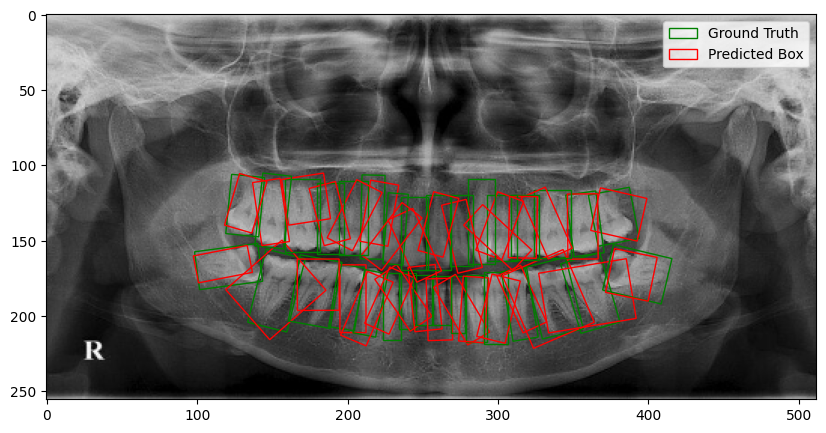

In [214]:
label = parse_label_file('./images/23.txt')
label = pad_labels(label, max_boxes =  33)

IMG_HEIGHT = 256
IMG_WIDTH = 512
image = torchvision.io.read_image('rgb_images/23.jpg').float() 
original_width, original_height = image.shape[2], image.shape[1]
resize_transform = torchvision.transforms.Resize((IMG_HEIGHT, IMG_WIDTH))
resized_image_X = resize_transform(image)
# print(resized_image_X.shape)
image = resized_image_X.permute(1,2,0) / 255.0
# print(image)

# Scale bounding boxes
scale_width = IMG_WIDTH / original_width
scale_height = IMG_HEIGHT / original_height
for gt_box in label:
    if gt_box[0] != -1:
      gt_box[1] = (gt_box[1] * scale_width) / IMG_WIDTH
      gt_box[2] = (gt_box[2] * scale_height) / IMG_HEIGHT
      gt_box[3] = (gt_box[3] * scale_width) / IMG_WIDTH
      gt_box[4] = (gt_box[4] * scale_height) / IMG_HEIGHT
      gt_box[5] = gt_box[5] / 360    # Normalize rotation


# Load and pad label

def rotate_box(box):
    """Calculate the four corners of a rotated box."""
    x_min, y_min, x_max, y_max, angle = box
    cx = (x_min + x_max) * 512 / 2
    cy = (y_min + y_max) * 256 / 2
    w = ( x_max - x_min ) * 512 
    h = (y_max - y_min ) * 256 
    angle = angle * 360
    angle = radians(angle)
    dx = w / 2
    dy = h / 2
    # Calculate the four corners of the rotated rectangle
    corners = np.array([
        [cx - dx * cos(angle) + dy * sin(angle), cy - dx * sin(angle) - dy * cos(angle)],
        [cx + dx * cos(angle) + dy * sin(angle), cy + dx * sin(angle) - dy * cos(angle)],
        [cx + dx * cos(angle) - dy * sin(angle), cy + dx * sin(angle) + dy * cos(angle)],
        [cx - dx * cos(angle) - dy * sin(angle), cy - dx * sin(angle) + dy * cos(angle)]
    ])
    return corners



img_copy = copy.deepcopy(image)
# boxes = anchors_assigned
# boxes = anchors_assigned.squeeze(0)
boxes = predicted_bbox_with_angle
boxes = predicted_bbox_with_angle.squeeze(0)

# bbox_scale = bbox_scale.repeat((boxes.shape[0], 1))
# boxes *= bbox_scale
# print(boxes)
boxes = boxes.tolist()
# print(labels[3])
labels = label[:,1:]
labels = labels.tolist()
# print(len(labels[3]))

print(boxes)
print(labels)

fig, ax = plt.subplots(figsize=(10, 5))  # Adjust width and height as needed
ax.imshow(img_copy)
# print(label)
# corners1 = rotate_box(labels[20])
# polygon1 = patches.Polygon(corners1, closed=True, fill=None, edgecolor='green', label='Ground Truth')


for label in tqdm(labels):
    corners1 = rotate_box(label)
    polygon1 = patches.Polygon(corners1, closed=True, fill=None, edgecolor='green', label='Ground Truth')
    max_iou = 0
    max_iou_box = None
    for box in boxes:
        corners2 = rotate_box(box)

        polygon2 = patches.Polygon(corners2, closed=True, fill=None, edgecolor='red', label='Predicted Box')

        area2 = polygon_area(corners2)
        area1 = polygon_area(corners1)
        inter_area = polygon_intersection(corners1, corners2)
        union_area = area1 + area2 - inter_area
        if union_area != 0:
            iou = inter_area / union_area
        # Change the IoU to see the different results
        if iou > max_iou:
            # ax.add_patch(polygon2)
            print(iou)
            print(box)
            max_iou = iou
            max_iou_box = box

    if max_iou_box:
        corners2 = rotate_box(max_iou_box)

        polygon2 = patches.Polygon(corners2, closed=True, fill=None, edgecolor='red', label='Predicted Box')
        ax.add_patch(polygon1)
        ax.add_patch(polygon2)

        plt.legend(handles=[polygon1, polygon2])

##### 4- This is the nms section

It is currently under construction ...

In [133]:
# resized_image_X.shape

In [134]:
# print(cls_preds.shape)
# print(predicted_bbox_with_angle.shape)

In [135]:
# print(torch.nonzero(predicted_bbox_with_angle))
# print(predicted_bbox_with_angle[18250,0], bbox_preds[18250, 0])

In [136]:
# # print(X.shape)
# def predict(X):
#   # net.eval()
#   net.eval()
#   anchors, cls_preds, bbox_preds = net(X.to(device))

#   # This is the added code
#   bbox_preds = bbox_preds * bbox_masks

#   cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
#   # print('Classifications probability: ', cls_probs)
#   print(cls_probs)
#   output = multibox_detection(cls_probs, bbox_preds, anchors)
#   print(output[0].shape)
#   idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
#   return output[0, idx]
# # output = predict(X)
# output = predict(resized_image_X.unsqueeze(0))

In [137]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import numpy as np
# from PIL import Image

# def rotate_box(box):
#     """Calculate the four corners of a rotated box (TensorFlow)."""
#     x_min, y_min, x_max, y_max, angle = box
#     cx = (x_min * 512 + x_max * 512)   / 2 
#     cy = (y_min * 256 + y_max * 256)  / 2 
#     dx = (x_max * 512 - x_min * 512) / 2  
#     dy = (y_max * 256 - y_min * 256) / 2  
#     angle = radians(angle * 360)
#     # angle = 0
#     # Calculate the four corners of the rotated rectangle
#     corners = [
#         (cx - dx * cos(angle) + dy * sin(angle), cy - dx * sin(angle) - dy * cos(angle)),
#         (cx + dx * cos(angle) + dy * sin(angle), cy + dx * sin(angle) - dy * cos(angle)),
#         (cx + dx * cos(angle) - dy * sin(angle), cy + dx * sin(angle) + dy * cos(angle)),
#         (cx - dx * cos(angle) - dy * sin(angle), cy - dx * sin(angle) + dy * cos(angle))
#     ]
#     return corners

# # Load the image
# # image_path = 'catdog.jpg'  # Replace with your actual image path
# # image = np.array(Image.open(image_path))
# # image = np.transpose(img.numpy())
# image = img.numpy()
# print(image.shape)
# # Example corners for rotated boxes
# # Define boxes as lists of four corners (top-left, top-right, bottom-right, bottom-left)
# # boxes = batch[1] [2, :, :].tolist()
# # print(boxes)

# corners_boxes = []
# # for box in boxes:
# #     if box[0] == -1:
# #         continue
# #     corners = rotate_box(box[1:])
# #     # print(corners)
# #     corners_boxes.append(corners)

# # boxes = corners_boxes


# fig, ax = plt.subplots(figsize=(10, 5))  # Adjust width and height as needed
# ax.imshow(image)

# for row in output.detach().cpu():
#     score = row[1]
#     if score < 0.03: # The threshold is so low!!!
#         continue
#     h, w = img.shape[:2]
#     bbox = row[2:7] 
#     corners = rotate_box(bbox)
#     corners_boxes.append(corners)  

# print(len(corners_boxes))

# # Draw each box as a polygon
# for corners in corners_boxes:
#     polygon = patches.Polygon(corners, closed=True, edgecolor='green', linewidth=2, facecolor='none')
#     ax.add_patch(polygon)


# plt.title("Image with Rotated Boxes")
# plt.axis("on")
# plt.show()